In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.autograd import Variable

from tqdm.notebook import tqdm

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### Use the CIFAR-10 dataset for all the experiments.

In [2]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

Files already downloaded and verified


#### Use a 70:30 data split.

In [3]:
train_size = int(len(dataset) * 0.70)
val_size = len(dataset) - train_size

In [4]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [5]:
batch_size=256

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
test_loader = DataLoader(test_dataset, batch_size)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Evaluation Method

In [7]:
def evaluate(model, data_lodr, weights_path="q1.pth"):
    
    # prework
    model.to(device)
    model.load_state_dict(torch.load(weights_path))

    #evaluation
    correct = 0
    total = 0
    
    for data in data_lodr:
        images, labels = Variable(data[0]).to(device), Variable(data[1]).to(device)
        
        with torch.no_grad():
            outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return (100 * correct / total)


### Training method

In [8]:
def train(model, train_lodr, val_lodr, epochs=20, weights_path="q1.pth", transfer_learning=False, save_weights=True, getacc=False):

    # Prework
    model.to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    if transfer_learning == True:
        model.load_state_dict(torch.load(weights_path))

    # Training
    print("Trainning Started...")

    train_loss = []
    val_loss = []

    train_acc = []

    for epoch in tqdm(range(epochs)):

        print("Epoch["+str(epoch)+"]:")

        # Training work
        train_running_loss = 0.0
        for i, data in enumerate(train_lodr, 0):
            
            inputs, labels = Variable(data[0]).to(device), Variable(data[1]).to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_running_loss += loss.item()
        
        train_loss.append(train_running_loss/ len(train_lodr))

        # Validation work
        val_running_loss = 0.0
        for i, data in enumerate(val_lodr, 0):
            
            inputs, labels = Variable(data[0]).to(device), Variable(data[1]).to(device)

            with torch.no_grad():
                outputs = model(inputs)   
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
        
        val_loss.append(val_running_loss/ len(val_lodr))

        print("\tTrain-Loss: "+str(train_loss[-1]))
        print("\tVal-Loss:   "+str(val_loss[-1]))

        if getacc == True:
            correct = 0
            total = 0
            
            for data in train_lodr:
                images, labels = Variable(data[0]).to(device), Variable(data[1]).to(device)
                
                with torch.no_grad():
                    outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_acc.append((100 * correct / total))


    print("Trainning Ended...")

    # post Work
    if save_weights == True:
        torch.save(model.state_dict(), weights_path)

    if getacc == False:
        return train_loss, val_loss
    else:
        return train_loss, val_loss, train_acc        

# Question 1
## No BatchNormalization

In [9]:
class Q1Net(nn.Module):
    def __init__(self):
        super(Q1Net, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=(1,1)),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc1 = nn.Linear(32 * 16 * 16, 10)

    def forward(self, x):
        
        x = self.conv_block1(x)
        x = x.view(-1, 32 * 16 * 16)
        x = self.fc1(x)
        
        return x

q1net = Q1Net()
q1net


Q1Net(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=8192, out_features=10, bias=True)
)

In [10]:
q1train_loss, q1val_loss = train(q1net, train_loader, val_loader, epochs=20, weights_path="q1_1.pth", transfer_learning=False, save_weights=True)

Trainning Started...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch[0]:
	Train-Loss: 2.0707879858295413
	Val-Loss:   1.9152040178492917
Epoch[1]:
	Train-Loss: 1.8773909537461553
	Val-Loss:   1.8214872671385942
Epoch[2]:
	Train-Loss: 1.8024084263474403
	Val-Loss:   1.7676992194127228
Epoch[3]:
	Train-Loss: 1.7560518962623428
	Val-Loss:   1.7387872206962716
Epoch[4]:
	Train-Loss: 1.7212333165816147
	Val-Loss:   1.7115643569978618
Epoch[5]:
	Train-Loss: 1.6949884143188922
	Val-Loss:   1.6818811004444705
Epoch[6]:
	Train-Loss: 1.6715228400961326
	Val-Loss:   1.662633152331336
Epoch[7]:
	Train-Loss: 1.6509147473495371
	Val-Loss:   1.6502111139944045
Epoch[8]:
	Train-Loss: 1.634175498120106
	Val-Loss:   1.6420058941437026
Epoch[9]:
	Train-Loss: 1.6154086824751248
	Val-Loss:   1.6260449381197912
Epoch[10]:
	Train-Loss: 1.60191495662188
	Val-Loss:   1.6105285317210827
Epoch[11]:
	Train-Loss: 1.5896751045310584
	Val-Loss:   1.6032844115111788
Epoch[12]:
	Train-Loss: 1.5751062187835247
	Val-Loss:   1.5834715467388347
Epoch[13]:
	Train-Loss: 1.5624329521708

In [11]:
q1accuracy = evaluate(q1net, test_loader, weights_path="q1_1.pth")
q1accuracy

47.95

# Question 2
## Two Dense Layers

In [12]:
class Q2Net(nn.Module):
    def __init__(self):
        super(Q2Net, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(num_features=32),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc1 = nn.Linear(32 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 10)

        self.relu = nn.ReLU()

    def forward(self, x):
        
        x = self.conv_block1(x)
        x = x.view(-1, 32 * 16 * 16)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

q2net = Q2Net()
q2net


Q2Net(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=8192, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)

In [13]:
q2train_loss, q2val_loss = train(q2net, train_loader, val_loader, epochs=20, weights_path="q1_2.pth", transfer_learning=False, save_weights=True)

Trainning Started...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch[0]:
	Train-Loss: 1.8245652365858538
	Val-Loss:   1.622268935381356
Epoch[1]:
	Train-Loss: 1.542277008077524
	Val-Loss:   1.4941687058594266
Epoch[2]:
	Train-Loss: 1.4304042941462385
	Val-Loss:   1.4171174178689212
Epoch[3]:
	Train-Loss: 1.3482567272047057
	Val-Loss:   1.3559632786249711
Epoch[4]:
	Train-Loss: 1.2840869583352639
	Val-Loss:   1.3224088984020685
Epoch[5]:
	Train-Loss: 1.2280174545998122
	Val-Loss:   1.2780495154655587
Epoch[6]:
	Train-Loss: 1.1808857091151885
	Val-Loss:   1.2605017948958834
Epoch[7]:
	Train-Loss: 1.1413382674655774
	Val-Loss:   1.2063402947732957
Epoch[8]:
	Train-Loss: 1.09933830221204
	Val-Loss:   1.189031164524919
Epoch[9]:
	Train-Loss: 1.0637665351811987
	Val-Loss:   1.1711717945034221
Epoch[10]:
	Train-Loss: 1.0337164889286905
	Val-Loss:   1.1465934898893713
Epoch[11]:
	Train-Loss: 1.006148225199567
	Val-Loss:   1.1402606095297863
Epoch[12]:
	Train-Loss: 0.9793404871529906
	Val-Loss:   1.1246163895574666
Epoch[13]:
	Train-Loss: 0.946215122720620

In [14]:
q2accuracy = evaluate(q2net, test_loader, weights_path="q1_2.pth")
q2accuracy

63.0

# Question 3
## 2 blocks of Conv2D -> BatchNorm2D->MaxPooling2D

In [15]:
class Q3Net(nn.Module):
    def __init__(self):
        super(Q3Net, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(num_features=32),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc1 = nn.Linear(64 * 8 * 8, 10)

    def forward(self, x):
        
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.fc1(x)
        
        return x

q3net = Q3Net()
q3net

Q3Net(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=10, bias=True)
)

In [16]:
q3train_loss, q3val_loss = train(q3net, train_loader, val_loader, epochs=20, weights_path="q1_3.pth", transfer_learning=False, save_weights=True)

Trainning Started...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch[0]:
	Train-Loss: 1.6599639480131385
	Val-Loss:   1.4690043118040441
Epoch[1]:
	Train-Loss: 1.3809156235117113
	Val-Loss:   1.356193986989684
Epoch[2]:
	Train-Loss: 1.254619007563069
	Val-Loss:   1.2361023122981443
Epoch[3]:
	Train-Loss: 1.1644649923282817
	Val-Loss:   1.1697058606955966
Epoch[4]:
	Train-Loss: 1.094558848081714
	Val-Loss:   1.1249112678786455
Epoch[5]:
	Train-Loss: 1.0423191481263099
	Val-Loss:   1.1174747701418601
Epoch[6]:
	Train-Loss: 1.00589136703171
	Val-Loss:   1.068165169934095
Epoch[7]:
	Train-Loss: 0.9699998115101
	Val-Loss:   1.0538141838574813
Epoch[8]:
	Train-Loss: 0.9412859860998001
	Val-Loss:   1.0445897528680705
Epoch[9]:
	Train-Loss: 0.9223514991085024
	Val-Loss:   1.0595959606817213
Epoch[10]:
	Train-Loss: 0.9047176685646503
	Val-Loss:   1.020971282053802
Epoch[11]:
	Train-Loss: 0.8812587900753439
	Val-Loss:   1.0170461282891743
Epoch[12]:
	Train-Loss: 0.8690426710748325
	Val-Loss:   1.0127893171067965
Epoch[13]:
	Train-Loss: 0.8574893365811257
	V

In [17]:
q3accuracy = evaluate(q3net, test_loader, weights_path="q1_3.pth")
q3accuracy

66.42

# Question 4
## 3 blocks of Conv2D -> BatchNorm2D->MaxPooling2D

In [18]:
class Q4Net(nn.Module):
    def __init__(self):
        super(Q4Net, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(num_features=32),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(num_features=128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc1 = nn.Linear(128 * 4 * 4, 10)

    def forward(self, x):
        
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(-1, 128 * 4 * 4)
        x = self.fc1(x)
        
        return x

q4net = Q4Net()
q4net


Q4Net(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2048, out_features=10, bias=True)
)

In [19]:
q4train_loss, q4val_loss = train(q4net, train_loader, val_loader, epochs=20, weights_path="q1_4.pth", transfer_learning=False, save_weights=True)

Trainning Started...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch[0]:
	Train-Loss: 1.644591781344727
	Val-Loss:   1.4363397642717524
Epoch[1]:
	Train-Loss: 1.322185581617982
	Val-Loss:   1.2579395164877683
Epoch[2]:
	Train-Loss: 1.1903404458595888
	Val-Loss:   1.1624883918438929
Epoch[3]:
	Train-Loss: 1.0940765638421053
	Val-Loss:   1.0963645961325048
Epoch[4]:
	Train-Loss: 1.0317108283077714
	Val-Loss:   1.05917783510887
Epoch[5]:
	Train-Loss: 0.9788531199859006
	Val-Loss:   1.0109084703154483
Epoch[6]:
	Train-Loss: 0.9366305635793366
	Val-Loss:   1.0082062866728185
Epoch[7]:
	Train-Loss: 0.9045121134632695
	Val-Loss:   0.9923354074106379
Epoch[8]:
	Train-Loss: 0.8718589365917401
	Val-Loss:   0.961759104567059
Epoch[9]:
	Train-Loss: 0.8447408319389733
	Val-Loss:   0.9431509981721135
Epoch[10]:
	Train-Loss: 0.82058476966663
	Val-Loss:   0.9358404551522207
Epoch[11]:
	Train-Loss: 0.7987941842879692
	Val-Loss:   0.9411252423868341
Epoch[12]:
	Train-Loss: 0.775802469166526
	Val-Loss:   0.918967250040022
Epoch[13]:
	Train-Loss: 0.7555316103635913
	

In [20]:
q4accuracy = evaluate(q4net, test_loader, weights_path="q1_4.pth")
q4accuracy

69.87

### Add a table contrasting the performance of the given architecture with all above variations. State your analysis.

In [21]:
from tabulate import tabulate

print("Accuracies: ", end="\n\n")
print(tabulate([[q1accuracy, q2accuracy, q3accuracy, q4accuracy]], headers=['Q1','Q2','Q3','Q4'], tablefmt="fancy_grid"))

Accuracies: 

╒═══════╤══════╤═══════╤═══════╕
│    Q1 │   Q2 │    Q3 │    Q4 │
╞═══════╪══════╪═══════╪═══════╡
│ 47.95 │   63 │ 66.42 │ 69.87 │
╘═══════╧══════╧═══════╧═══════╛


### Plots

In [22]:
epochs=20
def plotlossgraph(x, y1, y2, title='Q1'):
    plt.plot(x, y1, 'g', label='Training loss')
    plt.plot(x, y2, 'b', label='validation loss')

    plt.title(title+'Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()

xepoch = range(1,epochs+1)

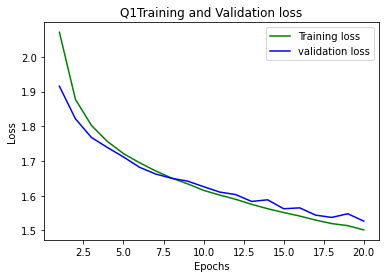

In [23]:
plotlossgraph(xepoch, q1train_loss, q1val_loss, title='Q1')

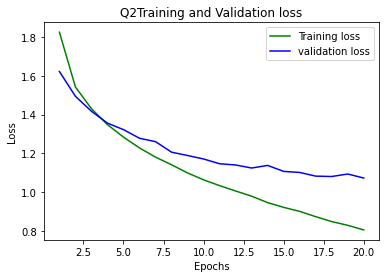

In [24]:
plotlossgraph(xepoch, q2train_loss, q2val_loss, title='Q2')

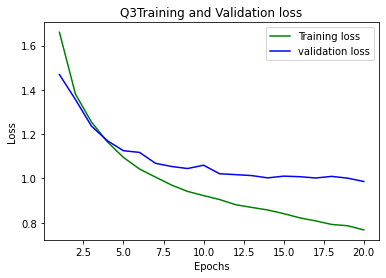

In [25]:
plotlossgraph(xepoch, q3train_loss, q3val_loss, title='Q3')

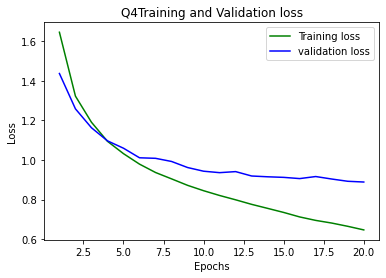

In [26]:
plotlossgraph(xepoch, q4train_loss, q4val_loss, title='Q4')

### Analysis

- Incresing the convolution blocks gives better results
    - As model can learn edegs in first layer
    - and shape and object (Here whole numeric digit) in subsequent layer
- Batch normalization accelerates training
    - in some cases by halving lesser the epochs
    - or better output
    - and provides some regularization
    - helps in reducing error

### Save the best model and plot the accuracy vs epoch

In [27]:
q4net = Q4Net()
q4net

Q4Net(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2048, out_features=10, bias=True)
)

In [28]:
_, _, train_acc = train(q4net, train_loader, val_loader, epochs=20, weights_path="q1_4.pth", transfer_learning=False, save_weights=True, getacc=True)

Trainning Started...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch[0]:
	Train-Loss: 1.6490586708932027
	Val-Loss:   1.4454516334048773
Epoch[1]:
	Train-Loss: 1.3414099947379454
	Val-Loss:   1.3051590333550662
Epoch[2]:
	Train-Loss: 1.2193025454987574
	Val-Loss:   1.1988948826062478
Epoch[3]:
	Train-Loss: 1.123433616474597
	Val-Loss:   1.1336981886524264
Epoch[4]:
	Train-Loss: 1.0591803836996538
	Val-Loss:   1.0834499173245187
Epoch[5]:
	Train-Loss: 1.001107006177415
	Val-Loss:   1.054605983071408
Epoch[6]:
	Train-Loss: 0.9640017208391732
	Val-Loss:   1.025752487829176
Epoch[7]:
	Train-Loss: 0.9261475027042584
	Val-Loss:   0.998810668112868
Epoch[8]:
	Train-Loss: 0.8884893046678418
	Val-Loss:   0.9818319617691686
Epoch[9]:
	Train-Loss: 0.8582047193589872
	Val-Loss:   0.9675148159770642
Epoch[10]:
	Train-Loss: 0.8300780588692992
	Val-Loss:   0.9638713709378647
Epoch[11]:
	Train-Loss: 0.8092916529544079
	Val-Loss:   0.948038898282132
Epoch[12]:
	Train-Loss: 0.7846015160971315
	Val-Loss:   0.9628832188703246
Epoch[13]:
	Train-Loss: 0.770080517243294

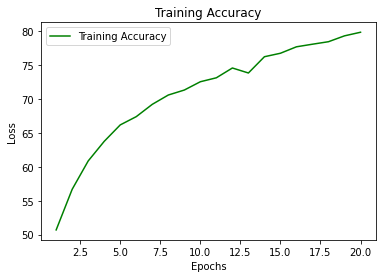

In [29]:
xepoch = range(1,20+1)
plt.plot(xepoch, train_acc, 'g', label='Training Accuracy')

plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()